In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
input_vector = 32
img_shape = (1, 28, 28)
batch_size = 128
epochs = 1000
lr = 0.0002
beta1 = 0.5


download the Dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(), # transoform [0,255] to [0,1]
    transforms.Normalize([0.5], [0.5]) # [0,1] to [-1,1]
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 409kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.32MB/s]


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.FC1 = nn.Linear(input_vector, 14 * 14 * 128)

        self.model = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # CORRECTED: Use kernel_size=3 with padding=1 to maintain 14×14
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # This goes from 14×14 to 28×28
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Final layer to get 1 channel
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.FC1(z)
        out = out.view(-1, 128, 14, 14)
        img = self.model(out)
        return img

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):

    super(Discriminator, self).__init__()
    self.model = nn.Sequential(

      #14,14,64
      nn.Conv2d(1,64, kernel_size=4, stride =2, padding=1),
      nn.LeakyReLU(0.2, inplace=True),

      #7,7,128
      nn.Conv2d(64,128, kernel_size=4, stride =2, padding=1),
      nn.LeakyReLU(0.2, inplace=True),

      #
      nn.Conv2d(128,256, kernel_size=4, stride =2, padding=1),
      nn.LeakyReLU(0.2, inplace=True),

    )

    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(256*3*3,1),
        nn.Sigmoid()
    )

  def forward(self, img):
    features = self.model(img)
    validity = self.fc(features)
    return validity




In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
print(generator)
print(f"\nNombre de paramètres: {sum(p.numel() for p in generator.parameters() if p.requires_grad)}")


Generator(
  (FC1): Linear(in_features=32, out_features=25088, bias=True)
  (model): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Tanh()
  )
)

Nombre de paramètres: 1107841


In [ ]:
print(discriminator)
print(f"\nNombre de paramètres: {sum(p.numel() for p in discriminator.parameters() if p.requires_grad)}")


Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2304, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

Nombre de paramètres: 659137


In [ ]:
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


Training Loop


=== Début de l'entraînement ===
Epoch 10/1000 - D loss: 0.5166, G loss: 1.2770


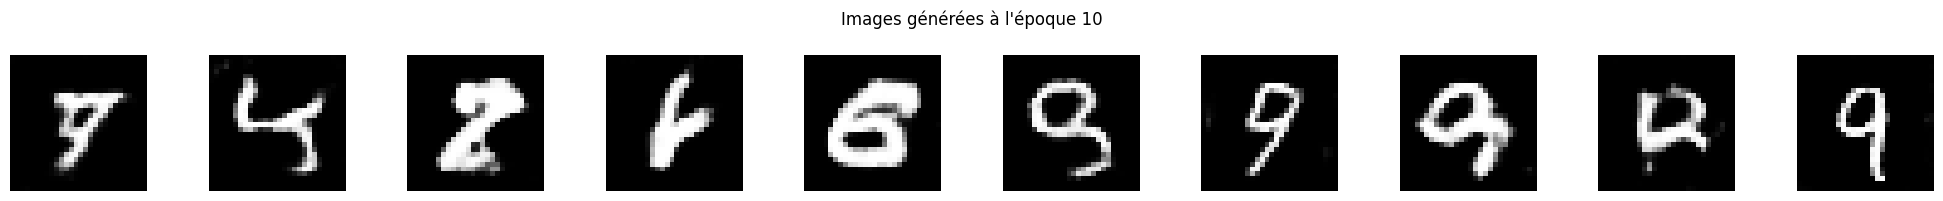

Epoch 20/1000 - D loss: 0.5091, G loss: 1.3154


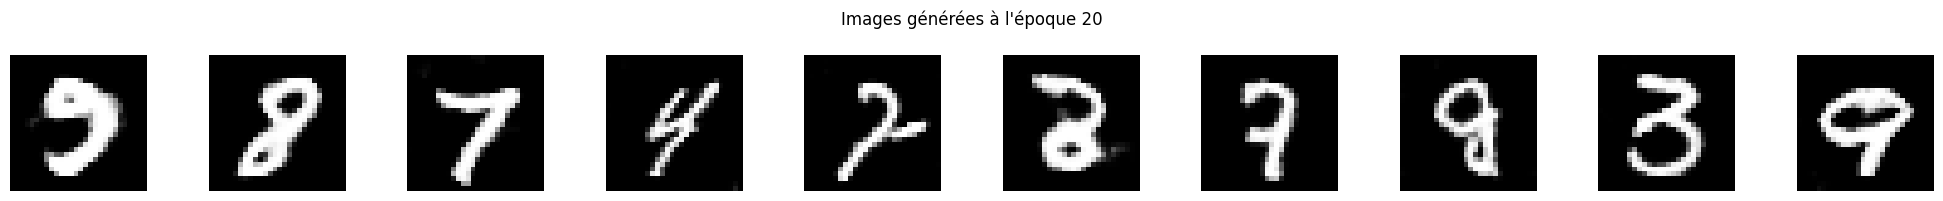

Epoch 30/1000 - D loss: 0.5034, G loss: 1.3553


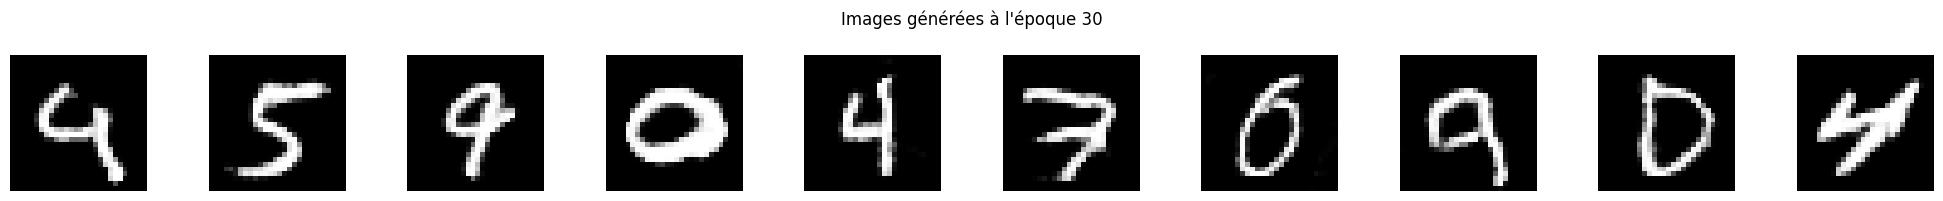

Epoch 40/1000 - D loss: 0.4984, G loss: 1.3674


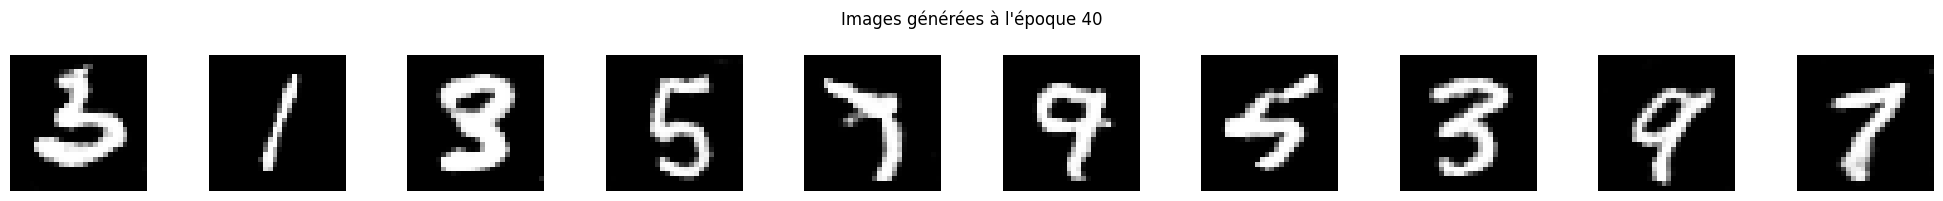

Epoch 50/1000 - D loss: 0.4918, G loss: 1.4154


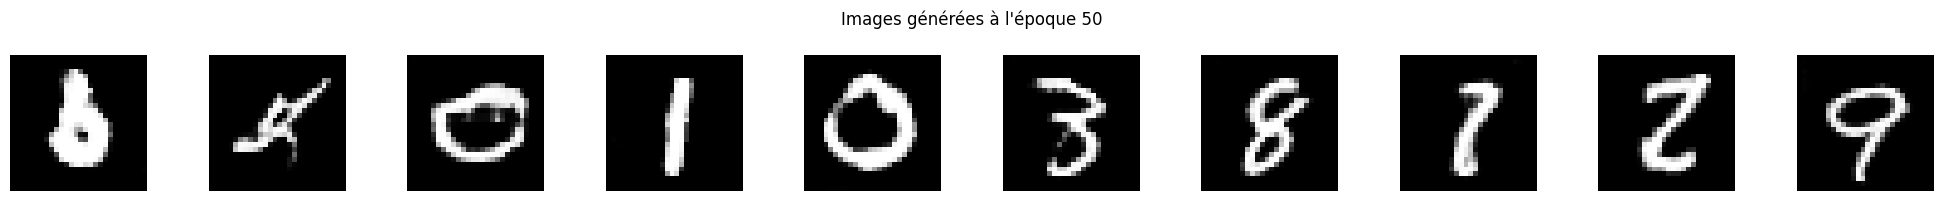

Epoch 60/1000 - D loss: 0.4832, G loss: 1.4440


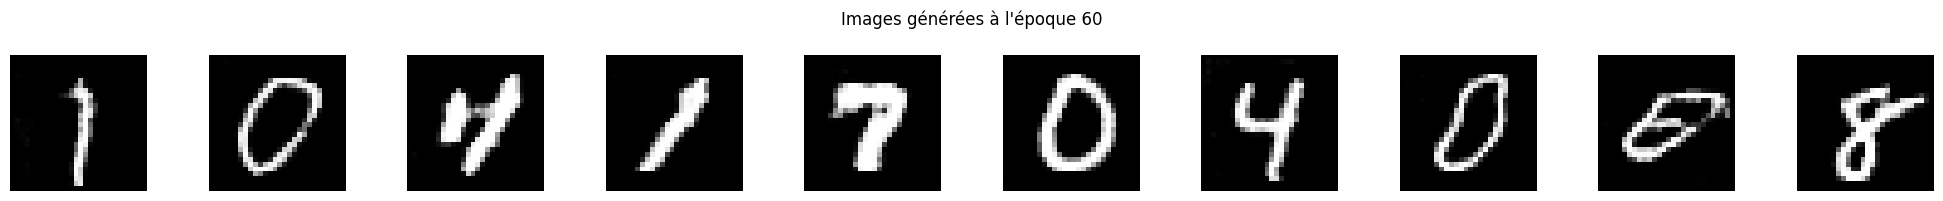

Epoch 70/1000 - D loss: 0.4757, G loss: 1.4757


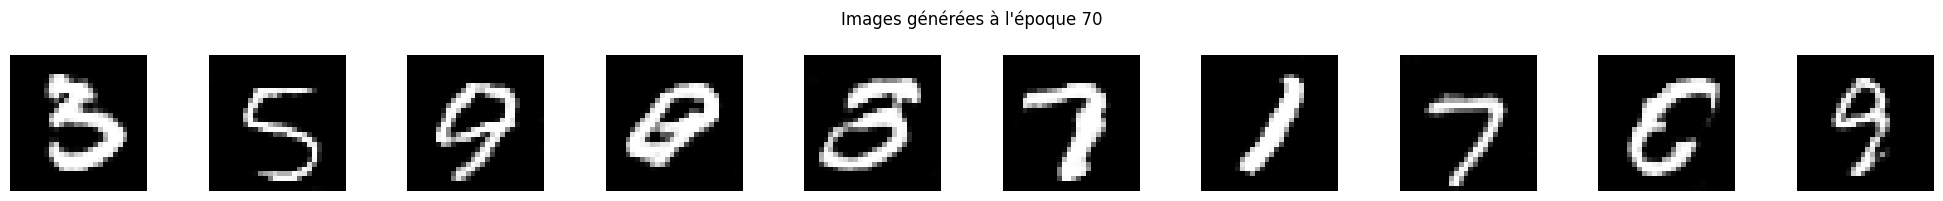

Epoch 80/1000 - D loss: 0.4637, G loss: 1.5266


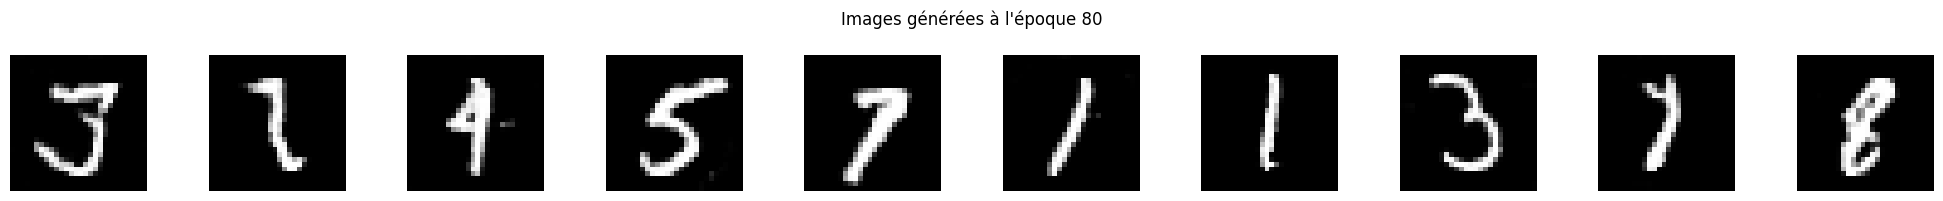

Epoch 90/1000 - D loss: 0.4549, G loss: 1.5710


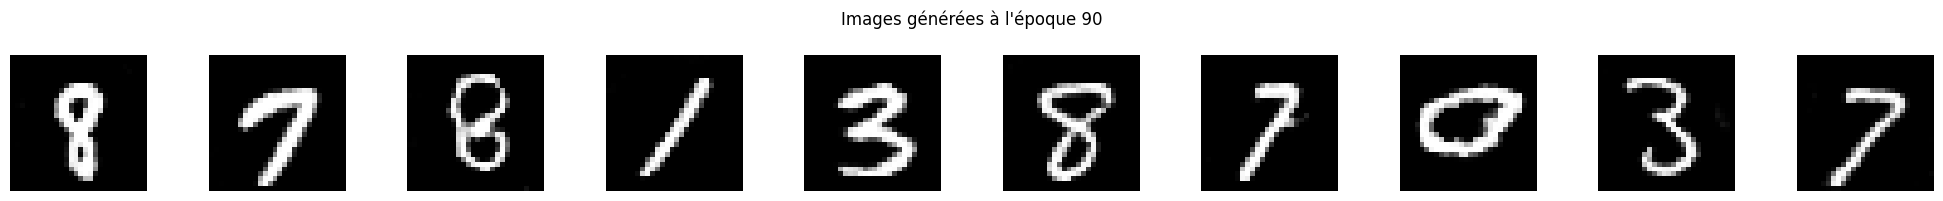

Epoch 100/1000 - D loss: 0.4444, G loss: 1.6224


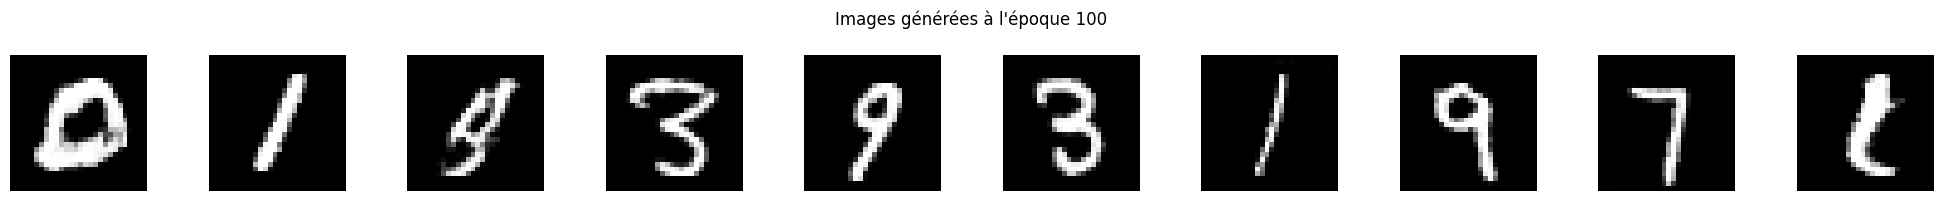

KeyboardInterrupt: 

In [ ]:
def train():
    generator_loss = []
    discriminator_loss = []

    for epoch in range(epochs):
        epoch_d_loss = 0
        epoch_g_loss = 0

        for batch_idx, (real_images, _) in enumerate(train_loader):
            current_batch_size = real_images.size(0)

            # Labels pour les images réelles et fausses
            labels_for_real_images = torch.ones(current_batch_size, 1).to(device)
            labels_for_fake_images = torch.zeros(current_batch_size, 1).to(device)

            real_images = real_images.to(device)

            # 5. Tirage aléatoire du code latent (distribution normale)
            input_noise = torch.randn(current_batch_size, input_vector).to(device)

            # ====== Entraîner le Discriminateur ======
            optimizer_D.zero_grad()

            # 6. Réaliser la prédiction des images générées à partir de G et du code latent
            fake_image = generator(input_noise).detach()  # detach pour ne pas calculer les gradients de G

            # 7. Construire un mélange d'images réelles et d'images générées avec les labels correspondants
            mixed_image = torch.cat([real_images, fake_image])
            mixed_labels = torch.cat([labels_for_real_images, labels_for_fake_images])

            # 8. Entraîner le discriminateur D à partir de ce mélange (équivalent de train_on_batch)
            output = discriminator(mixed_image)
            d_loss = criterion(output, mixed_labels)
            d_loss.backward()
            optimizer_D.step()

            # ====== Entraîner le Générateur (réseau antagoniste) ======
            # 9. Réaliser un nouveau tirage aléatoire du code latent, et créer les labels correspondants à "réel"
            input_noise = torch.randn(current_batch_size, input_vector).to(device)

            # 10. Entraîner le réseau antagoniste (équivalent de train_on_batch)
            optimizer_G.zero_grad()
            fake_images = generator(input_noise)
            output = discriminator(fake_images)
            g_loss = criterion(output, labels_for_real_images)  # Labels "réel" pour tromper D
            g_loss.backward()
            optimizer_G.step()

            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()

        # Moyenne des losses pour l'époque
        avg_d_loss = epoch_d_loss / len(train_loader)
        avg_g_loss = epoch_g_loss / len(train_loader)
        discriminator_loss.append(avg_d_loss)
        generator_loss.append(avg_g_loss)

        # Affichage toutes les 10 époques
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs} - D loss: {avg_d_loss:.4f}, G loss: {avg_g_loss:.4f}")

            # Tracer 10 images générées
            generator.eval()
            with torch.no_grad():
                noise = torch.randn(10, input_vector).to(device)
                generated_imgs = generator(noise).cpu()
                generated_imgs = (generated_imgs + 1) / 2  # Dénormaliser de [-1, 1] à [0, 1]

            fig, axes = plt.subplots(1, 10, figsize=(20, 2))
            for i in range(10):
                axes[i].imshow(generated_imgs[i, 0], cmap='gray')
                axes[i].axis('off')
            plt.suptitle(f'Images générées à l\'époque {epoch + 1}')
            plt.tight_layout()
            plt.show()

            generator.train()

    # Tracer l'évolution des losses
    plt.figure(figsize=(10, 5))
    plt.plot(discriminator_loss, label='Discriminator Loss')
    plt.plot(generator_loss, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Evolution des losses pendant l\'entraînement')
    plt.grid(True)
    plt.show()

# Lancer l'apprentissage
print("\n=== Début de l'entraînement ===")
train()

🎯 Device: cuda
🚀 TÉLÉCHARGEMENT CELEB-A RAPIDE...
Téléchargement échoué, utilisation dataset synthétique
[/content/data/celeba/celeba_mini.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/data/celeba/celeba_mini.zip or
        /content/data/celeba/celeba_mini.zip.zip, and cannot find /content/data/celeba/celeba_mini.zip.ZIP, period.
✅ Celeb-A mini téléchargé!

🎯 INITIALISATION DES MODÈLES...
✅ Générateur: 3,584,896 paramètres
✅ Discriminateur: 2,765,569 paramètres

🧪 TEST DES MODÈLES...
✅ Générateur testé - Output: torch.Size([4, 3, 64, 64])
✅ Discriminateur testé - Predictions: torch.Size([4, 1])
   Valeurs: [[0.3446165 ]
 [0.5245007 ]
 [0.6575821 ]
 [0.53228563]]


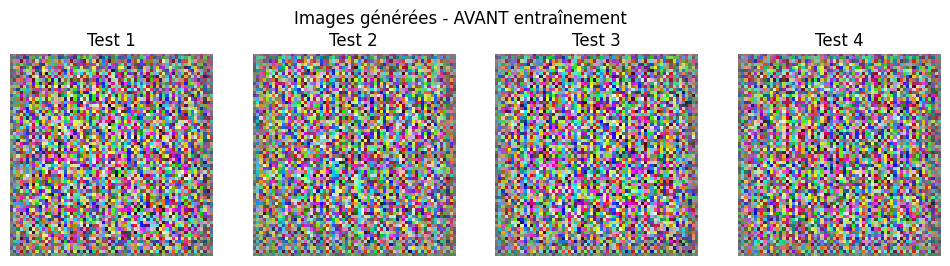

🎮 LANCEMENT DE L'ENTRAÎNEMENT...

🚀 DÉBUT ENTRAÎNEMENT - 30 ÉPOQUES
ℹ️  Création dataset synthétique...
✅ Dataset synthétique créé: 10000 images
📊 Epoch 5/30 - D_loss: 0.3817, G_loss: 5.1509


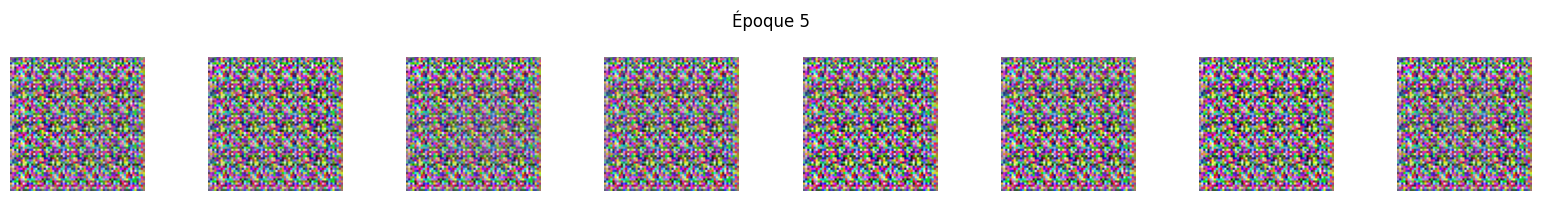

📊 Epoch 10/30 - D_loss: 0.2690, G_loss: 5.5763


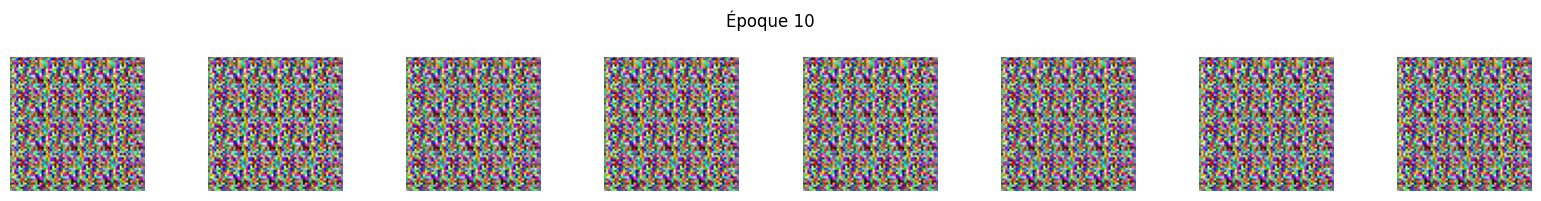

📊 Epoch 15/30 - D_loss: 0.2231, G_loss: 6.1177


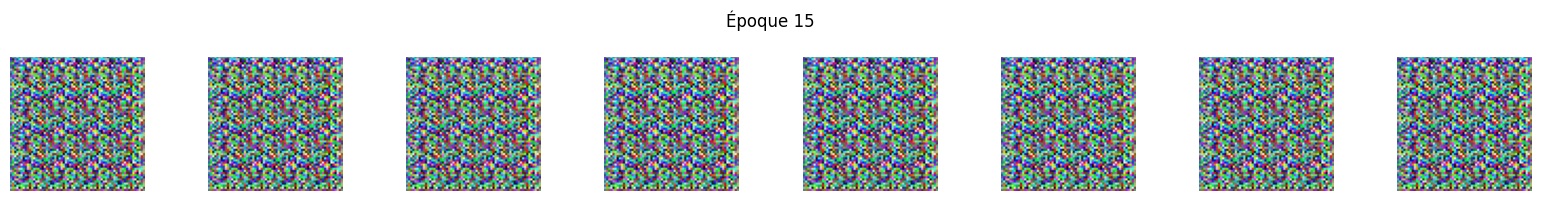

📊 Epoch 20/30 - D_loss: 0.2809, G_loss: 6.4728


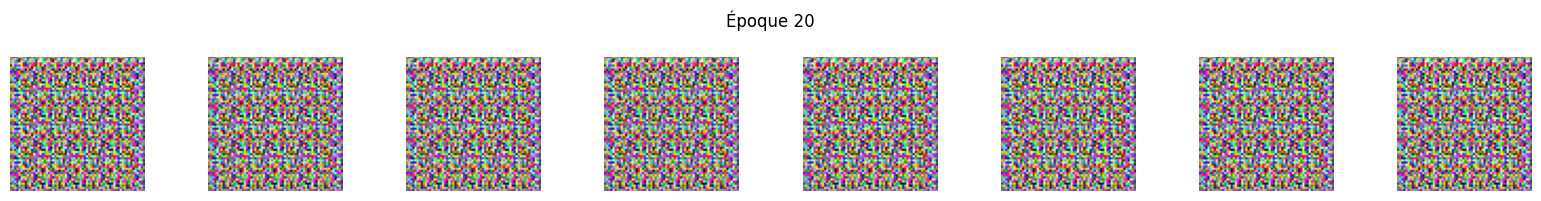

📊 Epoch 25/30 - D_loss: 0.2936, G_loss: 6.3348


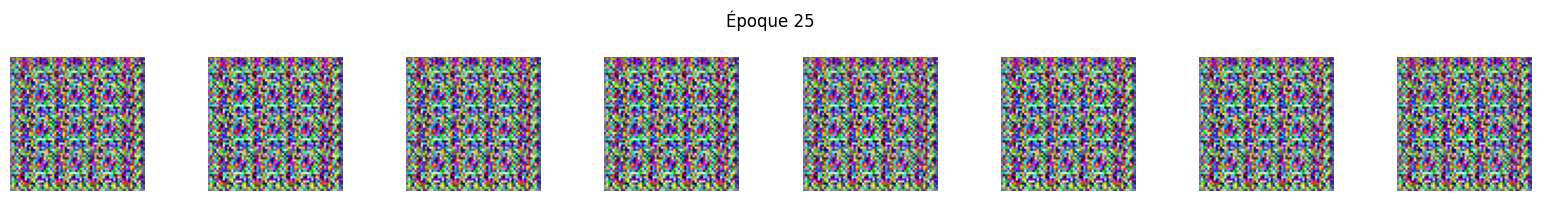

📊 Epoch 30/30 - D_loss: 0.3370, G_loss: 4.7090


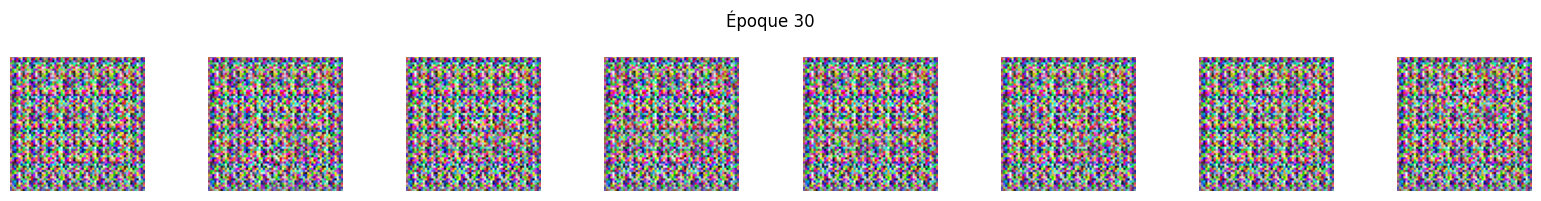

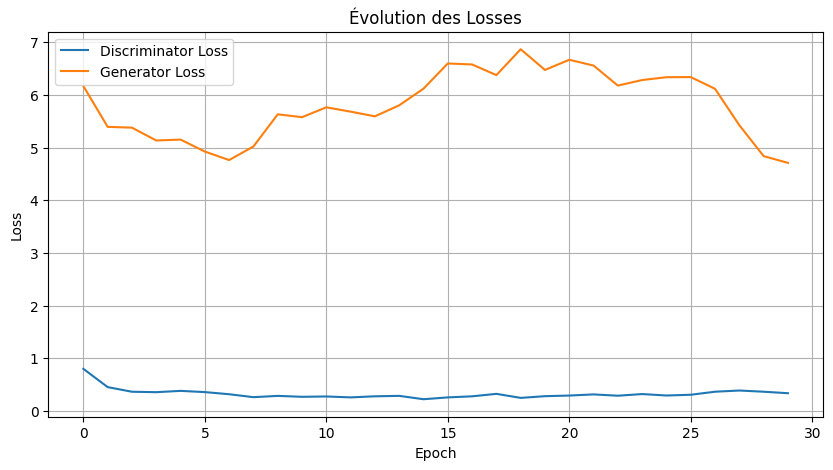


🎉 ENTRAÎNEMENT TERMINÉ!
🧪 TEST FINAL DU GÉNÉRATEUR...


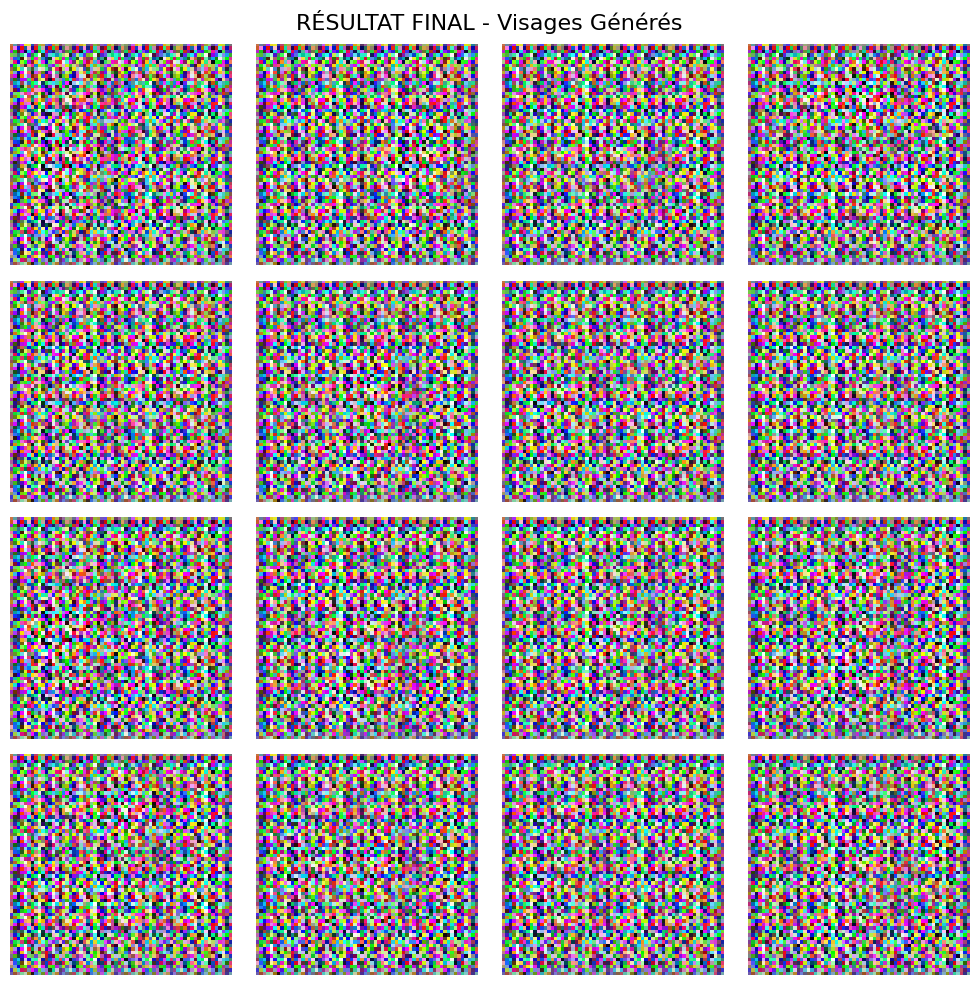

✨ GAN PRÊT! Vous pouvez générer des visages réalistes!
💡 Essayez de modifier latent_dim, epochs ou l'architecture pour améliorer les résultats
💾 Modèles sauvegardés: generator_final.pth, discriminator_final.pth


In [ ]:
# ====== INSTALLATION AND IMPORTS ======
!pip install -q torchvision matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# ====== CELEB-A DOWNLOAD ======
print("Downloading Celeb-A dataset...")
os.makedirs('/content/data/celeba', exist_ok=True)

# Download using wget
!wget -O /content/data/celeba/celeba_mini.zip "https://github.com/taesungp/contrastive-unpaired-translation/releases/download/v1.0/celeba_mini.zip" 2>/dev/null || echo "Download failed, using synthetic dataset"

if os.path.exists('/content/data/celeba/celeba_mini.zip'):
    !unzip -q /content/data/celeba/celeba_mini.zip -d /content/data/celeba/
    print("Celeb-A mini downloaded successfully!")
else:
    print("Using synthetic dataset")

# ====== GENERATOR ARCHITECTURE ======
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        
        # Start from 4x4 to reach 64x64
        self.init_size = 4
        self.fc = nn.Linear(latent_dim, 512 * self.init_size * self.init_size)
        
        self.model = nn.Sequential(
            # (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            # Upsample to 8x8
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # Upsample to 16x16
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # Upsample to 32x32
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # Upsample to 64x64
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()  # Output between [-1, 1]
        )
    
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 512, self.init_size, self.init_size)
        return self.model(x)

# ====== DISCRIMINATOR ARCHITECTURE ======
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # Input: (3, 64, 64)
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (64, 32, 32)
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (128, 16, 16)
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (256, 8, 8)
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (512, 4, 4) -> Flatten -> 512*4*4 = 8192
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        return self.model(img)

# ====== DATA LOADING ======
def get_dataloader():
    # Resize to 64x64 to match generator output
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    
    # Try to load Celeb-A
    try:
        if os.path.exists('/content/data/celeba/celeba'):
            dataset = datasets.CelebA(
                root='/content/data',
                split='train',
                transform=transform,
                download=False
            )
        else:
            dataset = datasets.CelebA(
                root='/content/data',
                split='train',
                transform=transform,
                download=True
            )
        print(f"Celeb-A loaded: {len(dataset)} images")
    except:
        # Synthetic dataset as backup
        print("Creating synthetic dataset...")
        class SyntheticDataset(torch.utils.data.Dataset):
            def __init__(self, num_samples=10000):
                self.num_samples = num_samples
                self.transform = transform
            
            def __len__(self):
                return self.num_samples
            
            def __getitem__(self, idx):
                img = torch.rand(3, 64, 64) * 2 - 1  # [-1, 1]
                return img, 0
        
        dataset = SyntheticDataset(10000)
        print(f"Synthetic dataset created: {len(dataset)} images")
    
    return DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2, drop_last=True)

# ====== MODEL INITIALIZATION ======
print("\nInitializing models...")
latent_dim = 100

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

print(f"Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")

# ====== MODEL TESTING ======
def test_models():
    print("\nTesting models...")
    
    # Test generator
    test_noise = torch.randn(4, latent_dim).to(device)
    fake_images = generator(test_noise)
    print(f"Generator output shape: {fake_images.shape}")
    
    # Test discriminator
    real_pred = discriminator(fake_images)
    print(f"Discriminator predictions shape: {real_pred.shape}")
    print(f"Prediction values: {real_pred.detach().cpu().numpy()}")
    
    # Display generated images
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for i in range(4):
        img = fake_images[i].detach().cpu()
        img = img * 0.5 + 0.5  # Denormalize to [0, 1]
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].set_title(f"Test {i+1}")
        axes[i].axis('off')
    plt.suptitle("Generated Images - BEFORE Training")
    plt.show()

# Run tests
test_models()

# ====== TRAINING CONFIGURATION ======
criterion = nn.BCELoss()
lr = 0.0002
beta1 = 0.5

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# ====== TRAINING FUNCTION ======
def train_gan(epochs=50):
    print(f"\nStarting training - {epochs} epochs")
    
    train_loader = get_dataloader()
    d_losses, g_losses = [], []
    
    for epoch in range(epochs):
        epoch_d_loss, epoch_g_loss = 0, 0
        
        for i, (real_images, _) in enumerate(train_loader):
            batch_size = real_images.size(0)
            
            # Labels
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            real_images = real_images.to(device)
            
            # ====== TRAIN DISCRIMINATOR ======
            optimizer_D.zero_grad()
            
            # Real images
            real_output = discriminator(real_images)
            real_loss = criterion(real_output, real_labels)
            
            # Fake images
            noise = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(noise).detach()
            fake_output = discriminator(fake_images)
            fake_loss = criterion(fake_output, fake_labels)
            
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()
            
            # ====== TRAIN GENERATOR ======
            optimizer_G.zero_grad()
            
            noise = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(noise)
            output = discriminator(fake_images)
            g_loss = criterion(output, real_labels)  # Fool the discriminator
            
            g_loss.backward()
            optimizer_G.step()
            
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
        
        # Average losses
        avg_d_loss = epoch_d_loss / len(train_loader)
        avg_g_loss = epoch_g_loss / len(train_loader)
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)
        
        # Display progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} - D_loss: {avg_d_loss:.4f}, G_loss: {avg_g_loss:.4f}")
            
            # Generate and display images
            generator.eval()
            with torch.no_grad():
                noise = torch.randn(8, latent_dim).to(device)
                generated = generator(noise).cpu()
                generated = (generated + 1) / 2  # [0, 1]
            
            fig, axes = plt.subplots(1, 8, figsize=(16, 2))
            for j in range(8):
                axes[j].imshow(generated[j].permute(1, 2, 0))
                axes[j].axis('off')
            plt.suptitle(f'Epoch {epoch+1}')
            plt.tight_layout()
            plt.show()
            
            generator.train()
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss Evolution')
    plt.grid(True)
    plt.show()
    
    return d_losses, g_losses

# ====== START TRAINING ======
print("Launching training...")
d_losses, g_losses = train_gan(epochs=200)

# ====== FINAL TEST ======
print("\nTraining completed!")
print("Final generator test...")

generator.eval()
with torch.no_grad():
    # Generate 16 images
    test_noise = torch.randn(16, latent_dim).to(device)
    final_images = generator(test_noise).cpu()
    final_images = (final_images + 1) / 2

# Display final results
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    ax = axes[i//4, i%4]
    ax.imshow(final_images[i].permute(1, 2, 0))
    ax.axis('off')
plt.suptitle('FINAL RESULTS - Generated Faces', fontsize=16)
plt.tight_layout()
plt.show()

print("GAN ready! You can now generate realistic faces!")
print("Tip: Try modifying latent_dim, epochs or architecture to improve results")

# ====== MODEL SAVING ======
torch.save(generator.state_dict(), 'generator_final.pth')
torch.save(discriminator.state_dict(), 'discriminator_final.pth')
print("Models saved: generator_final.pth, discriminator_final.pth")

# cGAN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model parameters
latent_dim = 32
num_classes = 10  # Digits 0-9
img_shape = (1, 28, 28)
batch_size = 128
epochs = 50
lr = 0.0001
beta1 = 0.4

# Load MNIST dataset (keeping labels this time)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# ====== Conditional Generator ======
class ConditionalGenerator(nn.Module):
    def __init__(self):
        super(ConditionalGenerator, self).__init__()
        
        # Input: z (latent_dim) + c (num_classes) = 32 + 10 = 42
        input_dim = latent_dim + num_classes
        
        # Dense layer that transforms input to (14x14x128)
        self.fc = nn.Linear(input_dim, 14 * 14 * 128)
        
        self.model = nn.Sequential(
            # (14x14x128)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Conv2DTranspose (14x14x128 -> 14x14x128)
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Conv2DTranspose (14x14x128 -> 28x28x64)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Final layer (28x28x1)
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        # Concatenate z and one-hot labels
        # z: [batch_size, latent_dim]
        # labels: [batch_size, num_classes]
        gen_input = torch.cat([z, labels], dim=1)  # [batch_size, latent_dim + num_classes]
        x = self.fc(gen_input)
        x = x.view(-1, 128, 14, 14)
        img = self.model(x)
        return img

# ====== Conditional Discriminator ======
class ConditionalDiscriminator(nn.Module):
    def __init__(self):
        super(ConditionalDiscriminator, self).__init__()
        
        # Embedding for labels: convert label to a "label map"
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        
        # Input: image (1 channel) + label_map (10 channels) = 11 channels
        self.model = nn.Sequential(
            # Input: (11, 28, 28) - image + label channels
            nn.Conv2d(1 + num_classes, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (64, 14, 14)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (128, 7, 7)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # (256, 3, 3)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img, labels):
        # img: [batch_size, 1, 28, 28]
        # labels: [batch_size] (class indices)
        
        # Create label maps for each image
        # Repeat one-hot encoding across the entire image
        batch_size = img.size(0)
        
        # Convert labels to one-hot
        labels_one_hot = torch.zeros(batch_size, num_classes).to(device)
        labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)
        
        # Spatially repeat to create label "images" (batch, 10, 28, 28)
        label_map = labels_one_hot.view(batch_size, num_classes, 1, 1)
        label_map = label_map.expand(batch_size, num_classes, 28, 28)
        
        # Concatenate image and label channels
        disc_input = torch.cat([img, label_map], dim=1)  # [batch_size, 11, 28, 28]
        
        features = self.model(disc_input)
        validity = self.fc(features)
        return validity

# Initialize models
generator = ConditionalGenerator().to(device)
discriminator = ConditionalDiscriminator().to(device)

print("=== Conditional Generator Architecture ===")
print(generator)
print(f"\nNumber of parameters: {sum(p.numel() for p in generator.parameters() if p.requires_grad)}")

print("\n=== Conditional Discriminator Architecture ===")
print(discriminator)
print(f"\nNumber of parameters: {sum(p.numel() for p in discriminator.parameters() if p.requires_grad)}")

# Optimizers and loss function
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# ====== Function to convert labels to one-hot ======
def to_one_hot(labels, num_classes=10):
    batch_size = labels.size(0)
    one_hot = torch.zeros(batch_size, num_classes).to(device)
    one_hot.scatter_(1, labels.unsqueeze(1), 1)
    return one_hot

# ====== CGAN Training ======
def train():
    generator_loss = []
    discriminator_loss = []
    
    for epoch in range(epochs):
        epoch_d_loss = 0
        epoch_g_loss = 0
        
        for batch_idx, (real_images, real_labels) in enumerate(train_loader):
            current_batch_size = real_images.size(0)
            
            # Labels for real/fake images
            labels_for_real_images = torch.ones(current_batch_size, 1).to(device)
            labels_for_fake_images = torch.zeros(current_batch_size, 1).to(device)
            
            real_images = real_images.to(device)
            real_labels = real_labels.to(device)
            
            # ====== Train Discriminator ======
            optimizer_D.zero_grad()
            
            # 5. Sample random noise
            input_noise = torch.randn(current_batch_size, latent_dim).to(device)
            
            # Sample random conditional labels (digits 0-9)
            fake_labels = torch.randint(0, num_classes, (current_batch_size,)).to(device)
            fake_labels_one_hot = to_one_hot(fake_labels)
            
            # 6. Generate conditioned images
            fake_image = generator(input_noise, fake_labels_one_hot).detach()
            
            # 7. Mix real and fake images with their labels
            mixed_image = torch.cat([real_images, fake_image])
            mixed_condition_labels = torch.cat([real_labels, fake_labels])
            mixed_labels = torch.cat([labels_for_real_images, labels_for_fake_images])
            
            # 8. Train conditional discriminator
            output = discriminator(mixed_image, mixed_condition_labels)
            d_loss = criterion(output, mixed_labels)
            d_loss.backward()
            optimizer_D.step()
            
            # ====== Train Generator ======
            # 9. New random sampling
            input_noise = torch.randn(current_batch_size, latent_dim).to(device)
            gen_labels = torch.randint(0, num_classes, (current_batch_size,)).to(device)
            gen_labels_one_hot = to_one_hot(gen_labels)
            
            # 10. Train generator
            optimizer_G.zero_grad()
            fake_images = generator(input_noise, gen_labels_one_hot)
            output = discriminator(fake_images, gen_labels)
            g_loss = criterion(output, labels_for_real_images)
            g_loss.backward()
            optimizer_G.step()
            
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
        
        # Average losses
        avg_d_loss = epoch_d_loss / len(train_loader)
        avg_g_loss = epoch_g_loss / len(train_loader)
        discriminator_loss.append(avg_d_loss)
        generator_loss.append(avg_g_loss)
        
        # Display every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs} - D loss: {avg_d_loss:.4f}, G loss: {avg_g_loss:.4f}")
            
            # Generate images for each digit (0-9)
            generator.eval()
            with torch.no_grad():
                # Create noise for each digit
                noise = torch.randn(10, latent_dim).to(device)
                # Create labels 0, 1, 2, ..., 9
                sample_labels = torch.arange(0, 10).to(device)
                sample_labels_one_hot = to_one_hot(sample_labels)
                
                generated_imgs = generator(noise, sample_labels_one_hot).cpu()
                generated_imgs = (generated_imgs + 1) / 2  # Denormalize
            
            fig, axes = plt.subplots(1, 10, figsize=(20, 2))
            for i in range(10):
                axes[i].imshow(generated_imgs[i, 0], cmap='gray')
                axes[i].set_title(f'Digit {i}')
                axes[i].axis('off')
            plt.suptitle(f'Generated images at epoch {epoch + 1} (conditioned by label)')
            plt.tight_layout()
            plt.show()
            
            generator.train()
    
    # Plot loss evolution
    plt.figure(figsize=(10, 5))
    plt.plot(discriminator_loss, label='Discriminator Loss')
    plt.plot(generator_loss, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss evolution during CGAN training')
    plt.grid(True)
    plt.show()

# Start training
print("\n=== Starting CGAN training ===")
train()

# ====== Function to generate specific digits ======
def generate_specific_digits(digit, num_samples=10):
    """Generate multiple examples of a specific digit"""
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_samples, latent_dim).to(device)
        labels = torch.full((num_samples,), digit, dtype=torch.long).to(device)
        labels_one_hot = to_one_hot(labels)
        
        generated_imgs = generator(noise, labels_one_hot).cpu()
        generated_imgs = (generated_imgs + 1) / 2
    
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))
    for i in range(num_samples):
        axes[i].imshow(generated_imgs[i, 0], cmap='gray')
        axes[i].axis('off')
    plt.suptitle(f'10 variations of digit {digit}')
    plt.tight_layout()
    plt.show()

# Example: generate 10 different versions of digit 7
print("\n=== Generating specific digits ===")
generate_specific_digits(7, num_samples=10)

# Save models
torch.save(generator.state_dict(), 'cgan_generator.pth')
torch.save(discriminator.state_dict(), 'cgan_discriminator.pth')
print("\nCGAN models saved!")